In [96]:
import networkx as nx
import numpy as np
import string
from random import sample
import torch

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [97]:
# G = nx.fast_gnp_random_graph(5, 0.2, directed=True)
# pos = nx.spring_layout(G)
# with plt.xkcd():
#     nx.draw_networkx(G, pos, arrowsize=10, with_labels=True, node_size=1000, node_color='black', edge_color='black',
#                     font_size=15, font_family='Bradley Hand')
#     plt.savefig('graph')

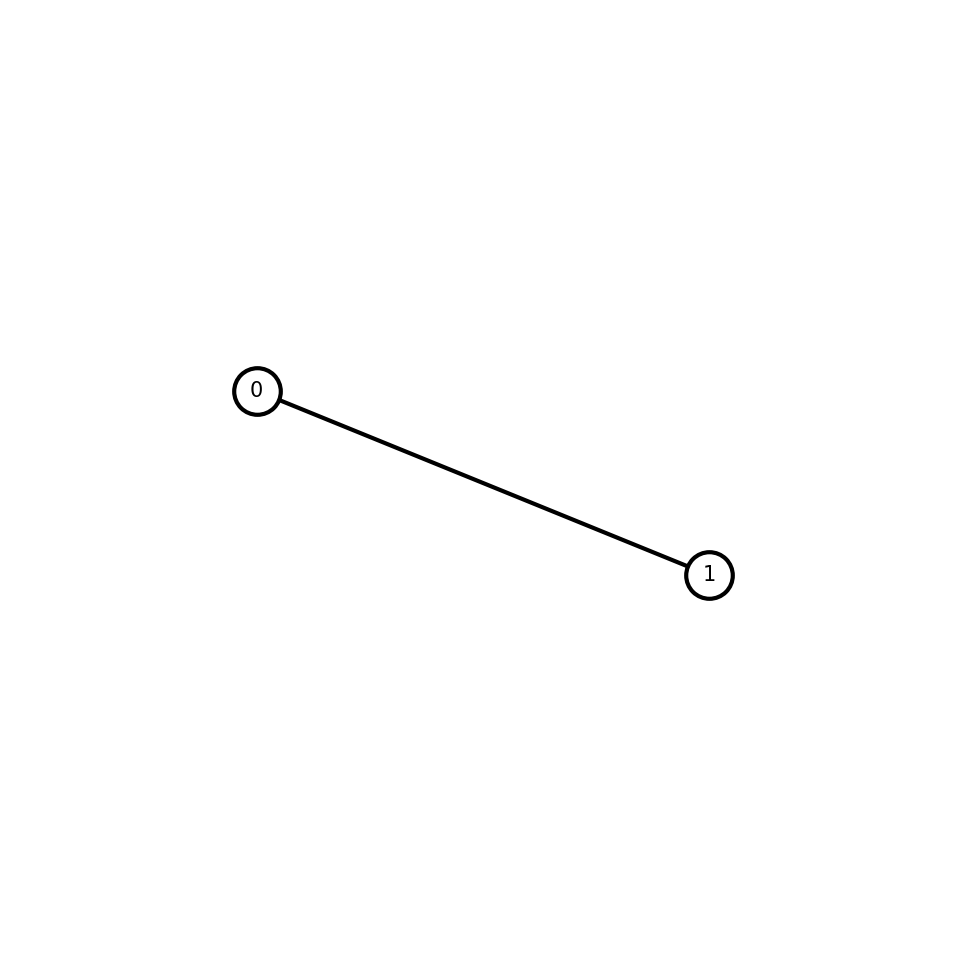

In [98]:
all_labels = list(string.ascii_lowercase) + list(range(0, 10))

n = 2
p = 1

# create graph
G = nx.fast_gnp_random_graph(n, p, directed=False)
# relabel nodes
# labels = dict(zip(pos.keys(), sample(all_labels, n)))
# nx.relabel_nodes(G, labels, copy=False)
# get positions
pos = nx.spring_layout(G)
adjacency = nx.adjacency_matrix(G).toarray()
G.remove_edges_from(list(nx.selfloop_edges(G)))

# draw graph
options = {
    "font_size": 5,
    "font_family": 'Bradley Hand',
    "node_size": 125,
    # "arrowsize": 25,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}

nx.draw_networkx(G, pos, **options)
# set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.axis("off")
plt.savefig('graph', bbox_inches='tight')
plt.show()

In [99]:
# Generate bounding box points for training data
radius = [(i + 1) * .1 for i in range(n)]
labels = [i for i in range(n)]
def format_box(x1, y1, x2, y2):
    return [min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)]


import math

boxes = np.array([[0, 0, 0, 0]])
for i in range(len(pos)):
    boxes = np.append(boxes, [format_box(pos[i][0] - radius[i], pos[i][1] - radius[i], pos[i][0] + radius[i], pos[i][1] + radius[i])], axis=0)

for i in range(len(adjacency)):
    for j in range(len(adjacency[i])):
        if adjacency[i][j] == 1:
            x1 = pos[i][0]
            y1 = pos[i][1]
            x2 = pos[j][0]
            y2 = pos[j][1]

            second_above = y2 > y1
            second_right = x2 > x1
            slope = (y2 - y1) / (x2 - x1)

            x_delta_abs1 = math.sqrt(radius[i]**2 / (1 + slope**2))
            y_delta_abs1 = abs(slope * x_delta_abs1)

            x_delta_abs2 = math.sqrt(radius[j]**2 / (1 + slope**2))
            y_delta_abs2 = abs(slope * x_delta_abs2)

            box_x1 = x1 + x_delta_abs1 if second_right else x1 - x_delta_abs1
            box_y1 = y1 + y_delta_abs1 if second_above else y1 - y_delta_abs1

            box_x2 = x2 - x_delta_abs2 if second_right else x2 + x_delta_abs2
            box_y2 = y2 - y_delta_abs2 if second_above else y2 + y_delta_abs2

      # boxes = np.append(boxes, [format_box(box_x1, box_y1, box_x2, box_y2)], axis=0)
out = {"labels": torch.Tensor(labels), "boxes": torch.Tensor(boxes)}


In [100]:
out["boxes"]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-1.1000,  0.3072, -0.9000,  0.5072],
        [ 0.8000, -0.6072,  1.2000, -0.2072]])

In [101]:
# Display bounding boxes
import torch
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms as T
from PIL import Image

img = Image.open('graph.png').convert('RGB')
t = T.functional.convert_image_dtype(T.ToTensor()(img), torch.uint8)


# Transform coordinates
for i in range(len(out["boxes"])):
    out["boxes"][i][0] = t.shape[2] / 2 + out["boxes"][i][0] * t.shape[2] / 4
    out["boxes"][i][2] = t.shape[2] / 2 + out["boxes"][i][2] * t.shape[2] / 4
    temp = t.shape[1] / 2 - out["boxes"][i][1] * t.shape[1] / 4
    out["boxes"][i][1] = t.shape[1] / 2 - out["boxes"][i][3] * t.shape[1] / 4
    out["boxes"][i][3] = temp

out["boxes"]


tensor([[482.5000, 483.0000, 482.5000, 483.0000],
        [217.1250, 360.5207, 265.3750, 408.8207],
        [675.5000, 533.0294, 772.0000, 629.6293]])

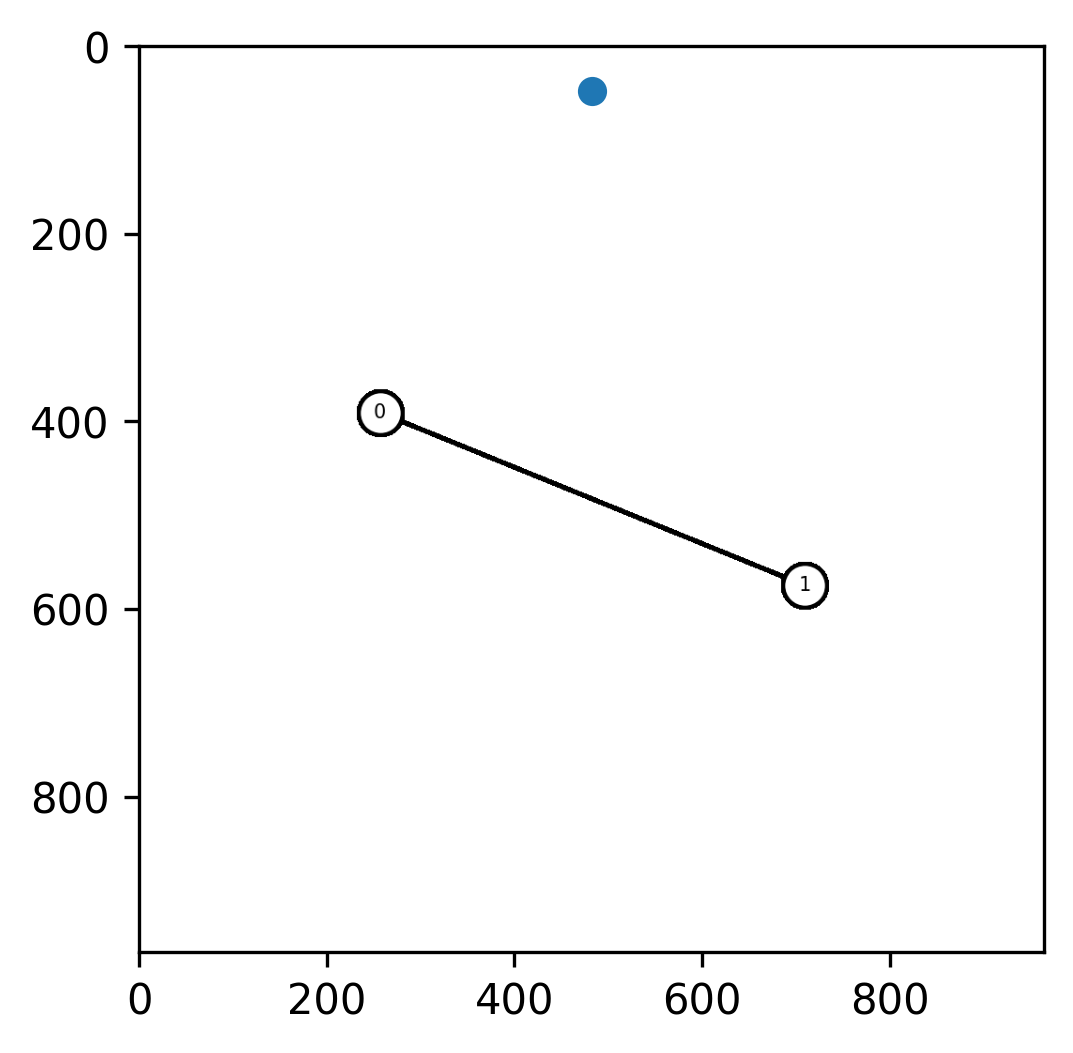

In [102]:
plt.imshow(img)
plt.scatter(482.5000,  48.0000)

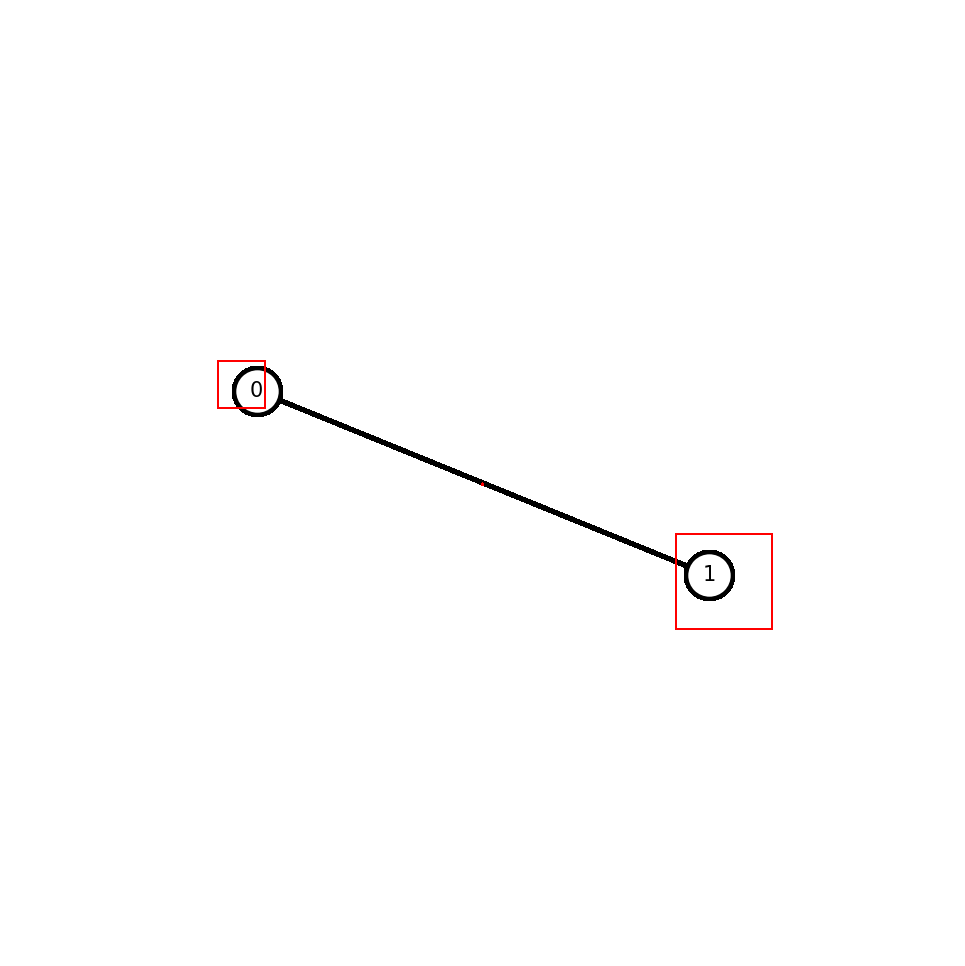

In [103]:
t_boxes = draw_bounding_boxes(t, out["boxes"], colors = 'red', width=2)
img_boxes = T.ToPILImage()(t_boxes)
img_boxes.show()

In [104]:
pos

{0: array([-1.        ,  0.40716079]), 1: array([ 1.        , -0.40716079])}